# Portafolios de Inversión
## Tarea 7

Presenta : 

- José Armando Melchor Soto


---
### Librerías 



In [2]:
import pandas as pd 
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize 

---

#### Indicaciones 

1.- Función de Métricas de Desempeño. (20%)

Genera una función en python que reciba un data frame con la evolución histórica de n cantidad de estrategías de inversión y calcule todas las métricas de desempeño vistas en las dos clases anteriores (Rendimiento, Volatilidad, Ratio de Sharpe, Downside, Upside, Omega, Beta, Alfa de Jensen, Ratio de Treynor, Ratio de Sortino).
 

2.- Backtesting de Portafolio. (50%)

Asume que quieres invertir en un portafolio compuesto por las siguientes acciones mexicanas: LIVEPOLC1.MX, KOFUBL.MX, CEMEXCPO.MX, CHDRAUIB.MX, CUERVO.MX, LABB.MX, RA.MX.
Debido a que no sabes como ponderarlos, decides realizar el backtesting para el portafolio para cuatro estrategias de Asset Allocation: Mínima Varianza, Máximo de Sharpe, Semivarianza Target y Omega.
Realiza el backtesting utilizando datos para simulación del 23-06-2024 hasta el 23-06-2025, toma un período anterior con el mismo horizonte temporal para optimizar las ponderaciones.
Recuerda siempre comparar con una estrategia de inversión pasiva, en este caso la opción lógica es el IPC México.
Gráfica la evolución histórica de las cinco alternativas de inversión.
Con los resultados del backtesting histórico calcula e interpreta las métricas de desempeño para las cinco alternativas de estrategias de inversión simuladas.
 

3.- Selección de Estrategia de Inversión. (20%)

Utilizando los resultados de tu backtesting y las métricas de desempeño, selecciona una estrategia de inversión. Realiza una conclusión clara, breve y robusta de porque es la mejor estrategia PARA TI, apoyate en las métricas obtenidas y en tu perfil de aversión al riesgo.
 

4.- Calculo de Pesos para Portafolio Real. (10%)

En base a la estrategia de Asset Allocation seleccionada en el punto anterior, calcula los pesos eficientes y la cantidad de acciones que utilizarías para invertir en la realidad en tu portafolio. Recuerda tomar la ventana de datos más reciente, en función del horizonte temporal tomado. 

---

#### Funciones 

##### Función Mínima Varianza 

In [3]:
def opt_min_var(rets):
    
    cov=rets.cov()
    n_assets = len(rets.columns)
    
    var = lambda w: w.T @ cov @ w
    
    w0=np.ones(n_assets)/n_assets
    
    bounds=[(0, 1)]*n_assets
    
    constraint=lambda w: sum(w)-1
    
    result=minimize(fun=var, x0=w0, bounds=bounds, constraints={'fun': constraint, 'type': 'eq'}, tol=1e-16)
    
    return result.x

##### Función Máximo de Sharpe

In [4]:
def opt_max_sharpe(rets, rf):
    
    E=rets.mean()
    cov=rets.cov()
    n_assets = len(rets.columns)
    
    rs = lambda w: -((w.T @ E - rf/252) / np.sqrt(w.T @ cov @ w))
    
    w0=np.ones(n_assets)/n_assets
    
    bounds=[(0, 1)]*n_assets
    
    constraint=lambda w: sum(w)-1
    
    result=minimize(fun=rs, x0=w0, bounds=bounds, constraints={'fun': constraint, 'type': 'eq'}, tol=1e-16)
    
    return result.x

##### Función Semi-Varianza Target

In [5]:
def objetivo (rets:pd.DataFrame , rets_b : pd.DataFrame ,corr:pd.DataFrame):
    
    rets, rets_b = rets.align(rets_b, join='inner', axis=0)
    diffs=rets - rets_b.values
    rends_below_bench = diffs[diffs < 0].fillna(0)
    target_downside_risk=np.array(rends_below_bench.std())
    target_semivarmatrix= corr * (target_downside_risk.reshape(len(rets.columns), 1) @ target_downside_risk.reshape(1, len(rets.columns)))

    objectivo = lambda w: (w.T @ target_semivarmatrix @ w)

    n = len(rets.keys())
    w_inicial = np.ones(n)/n
    bounds = [(0,1)]*n
    tol = 1e-9
    rest = lambda w: np.sum(w) - 1
    
    obj = minimize(
    fun=objectivo,
    x0=w_inicial,
    bounds=bounds,
    constraints={'fun': rest, 'type': 'eq'},
    tol=tol)

    w_objetivo = obj.x

    return dict(zip(rets.columns, w_objetivo))

##### Función Omega


In [6]:
def scipy_omega(rets: pd.DataFrame):
    n = len(rets.columns)
    w_inicial = np.ones(n) / n
    bounds = [(0, 1)] * n
    tol = 1e-16

    rets_below_zero = rets[rets < 0].fillna(0)
    rets_above_zero = rets[rets > 0].fillna(0)
    upside_risk=rets_above_zero.std()
    downside_risk = rets_below_zero.std()

    omega_ind = upside_risk / downside_risk

    Omega_neg = lambda w: -np.sum(w * omega_ind)

    constraints = {'fun': lambda w: np.sum(w) - 1, 'type': 'eq'}

    result = minimize(
        fun=Omega_neg,
        x0=w_inicial,
        bounds=bounds,
        constraints=constraints,
        tol=tol
    )

    w_omega = result.x
    return dict(zip(rets.columns, w_omega))


##### Función Backtesting 

In [7]:
def backtesting(prices: pd.DataFrame, benchmark: pd.DataFrame, weights: dict, capital: float):
    
    # Obtener rendimientos de precios y benchmark
    rets_assets = prices.pct_change().dropna()
    rets_benchmark = benchmark.pct_change().dropna()
    
    # data frame vacio para llenar historia
    
    df = pd.DataFrame(index=rets_assets.index)
    
    # Obtener evolución para cada estrategia dada
    for strategy in weights.keys():
        # para benchmark
        if strategy == 'benchmark':
            temp = rets_benchmark + 1
            temp.iloc[0]=capital
            temp = temp.cumprod()
            df[strategy] = temp.values            
    
        # para otras estrategias

        else:
            temp = (rets_assets * weights.get(strategy)).sum(axis=1)+1
            temp.iloc[0]=capital
            temp = temp.cumprod()
            df[strategy] = temp.values    

    # Graficar la evolucion para ambos portafolios
    plt.figure(figsize=(12,6))
    plt.plot(df, label=df.keys())
    plt.title('Backtesting of Strategies')
    plt.xlabel('Date')
    plt.ylabel('Portafolio Value')
    plt.legend()
    plt.show()


    return df

##### Función Métricas de Desempeño

In [8]:
def metricas_anuales(history, rf):
    # Returns
    rets= history.pct_change().dropna()
    
    # Matriz de Cov
    cov_hist = rets.cov()

    # Dataframe
    metricas = pd.DataFrame(index=rets.columns)

    # Rendimiento 
    metricas['Rendimiento Promedio Anual'] = R_p = rets.mean()*252*100
    
    # Volatilidad 
    metricas['Volatilidad Anual'] = vol_anual = rets.std()*np.sqrt(252)*100
    
    # Ratio de Sharpe
    metricas['Ratio de Sharpe'] = (R_p - rf) / vol_anual

    # Downside Risk
    metricas['Downside Risk'] = downside = rets[rets < 0].std() * np.sqrt(252) * 100

    # Upside Risk
    metricas['Upside Risk'] = upside = rets[rets > 0].std() * np.sqrt(252) * 100

    # Omega
    metricas['Omega'] =omega= upside / downside

    # Beta

    covs = cov_hist['Benchmark']
    varianza_market = covs['Benchmark']
    metricas['Beta'] = beta = covs / varianza_market

    # Alfa de Jensen

    R_m = rets['Benchmark']
    alpha_Jensen = R_p - (rf + beta * (R_m - rf))

    # Ratio de Treynor
    metricas['Ratio de Treynor'] = (R_p - rf) / beta

    # Ratio de Sortino
    metricas['Ratio de Sortino'] = (R_p - rf) / downside

    return metricas.T


---

#### Construcción del Portafolio 

##### Activos 

| **Empresa**                             | **Ticker**        | **Sector Económico**                          |
|----------------------------------------|-------------------|-----------------------------------------------|
| El Puerto de Liverpool, S.A.B. de C.V. | LIVEPOLC-1.MX     | Consumo                 |
| Coca-Cola FEMSA, S.A.B. de C.V.        | KOFUBL.MX         | Consumo Básico             |
| Cemex, S.A.B. de C.V.                  | CEMEXCPO.MX       | Materiales           |
| Grupo Comercial Chedraui               | CHDRAUIB.MX       | Consumo Básico          |
| Becle, S.A.B. de C.V. (José Cuervo)    | CUERVO.MX         | Consumo Básico       |
| Genomma Lab Internacional, S.A.B. de C.V. | LABB.MX         | Salud  |
| Rassini, S.A.B. de C.V.                | RA.MX             | Industriales                   |



##### Benchmark

- (IPC) Índice de Precios y Cotizaciones de la Bolsa Mexicana de Valores (^MXX).

---

#### Importación de los datos

In [9]:
tickers = ['LIVEPOLC-1.MX', 'KOFUBL.MX', 'CEMEXCPO.MX', 'CHDRAUIB.MX', 'CUERVO.MX', 'LABB.MX', 'RA.MX']

opt_prices = yf.download(tickers, start='2023-06-23', end='2024-06-23', progress=False)['Close']

bt_prices = yf.download(tickers,  start='2024-06-23', end='2025-06-23', progress=False)['Close']

benchmark = yf.download(['^MXX'], start='2024-06-23', end='2025-06-23', progress=False)['Close']

YF.download() has changed argument auto_adjust default to True


##### Rendimientos activos

In [10]:
opt_rets = opt_prices.pct_change().dropna()
corr = opt_rets.corr()

##### Rendimientos benchmark

In [ ]:
rets_b = benchmark.pct_change().dropna()+1

---

#### Asset Allocation 

##### Mínima Varianza

In [12]:
w_minvar = opt_min_var(opt_rets)
dict(zip(opt_rets.columns, w_minvar))

{'CEMEXCPO.MX': 0.04611909247813237,
 'CHDRAUIB.MX': 0.30905624737915166,
 'CUERVO.MX': 0.11713471695671539,
 'KOFUBL.MX': 0.21646746457064273,
 'LABB.MX': 0.0014374896719789433,
 'LIVEPOLC-1.MX': 0.2471786744184068,
 'RA.MX': 0.06260631452497217}

##### Máximo de Sharpe 

In [13]:
w_maxsharpe = opt_max_sharpe(opt_rets, rf=0.045)
dict(zip(opt_rets.columns, w_maxsharpe))

{'CEMEXCPO.MX': 1.5723497334440072e-17,
 'CHDRAUIB.MX': 0.5377960551043257,
 'CUERVO.MX': 8.374336929910183e-17,
 'KOFUBL.MX': 8.17363828825133e-18,
 'LABB.MX': 0.09006444151799088,
 'LIVEPOLC-1.MX': 0.37213950337768337,
 'RA.MX': 0.0}

##### Semi-Varianza target

In [14]:
w_semivar= objetivo(opt_rets, rets_b, corr)
w_semivar

{'CEMEXCPO.MX': 0.14285714285714285,
 'CHDRAUIB.MX': 0.14285714285714285,
 'CUERVO.MX': 0.14285714285714285,
 'KOFUBL.MX': 0.14285714285714285,
 'LABB.MX': 0.14285714285714285,
 'LIVEPOLC-1.MX': 0.14285714285714285,
 'RA.MX': 0.14285714285714285}

##### Ratio Omega

In [15]:
omega = scipy_omega(opt_rets)
omega

{'CEMEXCPO.MX': 6.967806737070939e-21,
 'CHDRAUIB.MX': 1.0,
 'CUERVO.MX': 9.030260362230184e-18,
 'KOFUBL.MX': 0.0,
 'LABB.MX': 0.0,
 'LIVEPOLC-1.MX': 1.5368326060975425e-16,
 'RA.MX': 1.4014017671459198e-17}

---

### Backtesting de Portafolio

##### Capital 

In [16]:
capital = 1000000

##### Estrategias a usar

In [17]:
w_dict = {
    'Min Varianza': w_minvar,
    'Max Sharpe': w_maxsharpe,
    'Semi-Varianza target': w_semivar,
    'Ratio Omega': omega,
    'Benchmark': 1
}

##### Función Aplicada 

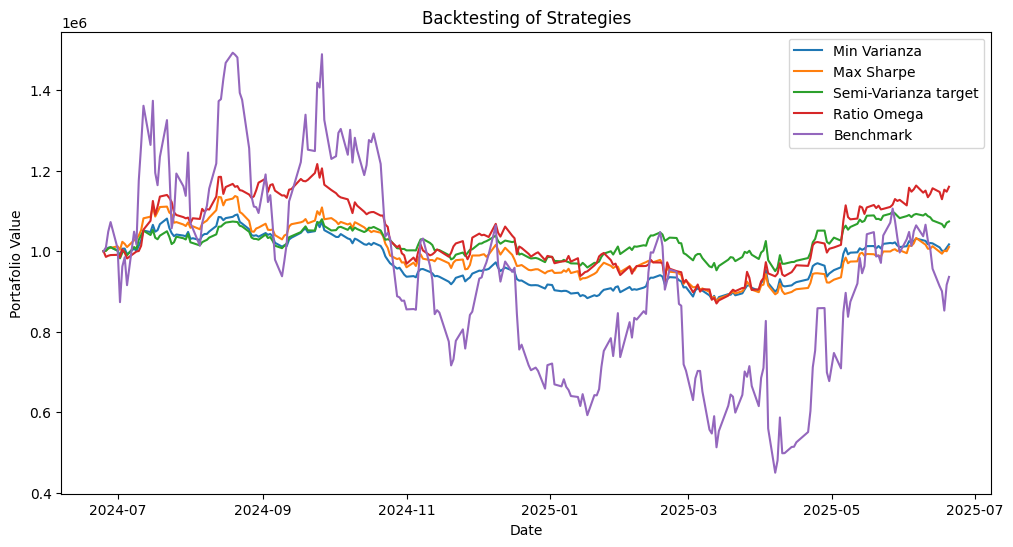

In [18]:
history = backtesting(bt_prices, benchmark, w_dict, capital)

#### Métricas de Desempeño

In [19]:
Desempeño = metricas_anuales(history, 0.045)
Desempeño

,Min Varianza,Max Sharpe,Semi-Varianza target,Ratio Omega,Benchmark
Rendimiento Promedio Anual,3.050151,2.787506,8.628321,18.722520,60.398246
Volatilidad Anual,16.299091,18.447180,16.368645,26.702499,114.580518
Ratio de Sharpe,0.184375,0.148668,0.524376,0.699467,0.526732
Downside Risk,10.253995,11.738907,11.459895,16.355630,80.219266
Upside Risk,10.305358,11.869967,9.840446,18.943980,68.883120
Omega,1.005009,1.011165,0.858685,1.158254,0.858685
Beta,0.126188,0.116060,0.142857,0.131461,1.000000
Ratio de Treynor,23.814913,23.630142,60.083246,142.076969,60.353246
Ratio de Sortino,0.293071,0.233625,0.748988,1.141963,0.752354


#### Interpretación

---

### Selección de Estrategias de Inversión 

##### Perfil de aversión al Riesgo  : Adverso al riesgo

---

### Calculo de Pesos para Portafolio Real

In [ ]:
re_opt = pd.DataFrame(index=  opt_rets.columns)
re_opt['w'] = opt_min_var(bt_prices)
re_opt['Cash'] = re_opt['w'] * capital
re_opt['No. Acciones'] = np.floor(re_opt['Cash'] / bt_prices.iloc[-1])
re_opt



,w,Cash,No. Acciones
Ticker,,,
CEMEXCPO.MX,0.698731,698730.565081,53997.0
CHDRAUIB.MX,0.000000,0.000000,0.0
CUERVO.MX,0.120592,120591.724200,5231.0
KOFUBL.MX,0.005437,5436.694937,30.0
LABB.MX,0.169428,169428.437420,8184.0
LIVEPOLC-1.MX,0.005813,5812.578362,61.0
RA.MX,0.000000,0.000000,0.0


In [29]:
re_opt['w'].sum()

1.000000000000006